# Assessing CpG content in long non-coding RNA promoters

The description of pervasive transcription across many mammalian
genomes has sparked an interest in the role of long non-coding RNAs in
diverse biological systems. Transcripts derived from non-coding loci
have been shown to be important in a number of different processes
including development and cancer.  However, some features that are
normally associated with protein coding genes are not observed in
lncRNAs e.g they are less conserved. Protein coding gene promoters
have a characteristically high GC content and CpG density. But do
lncRNAs display the same bias in their promoters? In this example we
show you how to use CGAT tools to answer this question. We will be
using::

    gtf2gtf
    gtf2gff
    gff2bed
    bed2fasta
    fasta2table

Our initial input file is a :term:`gtf` formatted file containing
genomic coordinates and annotations for a set of lncRNAs -
lncRNA.gtf.gz. We can compute the GC and CpG composition using a
single command line statement using multiple CGAT tools. However, as
described in :ref:`quickstart`, we require an CGAT indexed genome as
input to both gtf2gff.py and bed2fasta.py. The first step is therefore
to create the indexed genome.

First let us obtain a set of human lincRNA from ENSEMBL:

    wget -qO- ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz
    | gunzip
    | awk "$2 == 'lincRNA'"
    | gzip
    > lncRNA.gtf.gz

In our example our lncRNA transcript models are from an RNA-seq
experiment in human cells. We can index the human hg19 reference
genome by downloading the :term:`fasta` formatted genome from the UCSC
website and running index_fasta.py:

	wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/chromFa.tar.gz |
	index_fasta.py hg19 > hg19.log

We can then use this indexed genome as additional input when required. 

The G+C content at promotors can then be computed with this command:

In [3]:
!zcat lincRNA.gtf.gz \
    | cgat gff2gff --method=sanitize --sanitize-method=genome --genome-file=hg19 --skip-missing \
    | cgat gtf2gtf --method=sort --sort-order=gene \
    | cgat gtf2gtf --method=merge-transcripts \
    | cgat gtf2gff --genome-file=hg19 --method=promotors -p 1500 --is-unsorted \
    | cgat gff2fasta --genome-file=hg19 \
    | cgat fasta2table --section=cpg \
    | gzip \
    > lincRNA_cpg.tsv.gz


The above commands in turn do the following:

* gff2gff:
    reconcile chromosome names in the gene set with those in the genome
    removing any genes on chromosome that are not in the genome such as
    ``HG1472_PATCH``.

* gtf2gtf:
    sorts the input file by gene identifier,

* gtf2gtf:
    merges transcripts that have the same gene identifier. Effectively
    we will be using the most 5' transcription start as our promotor.
    Other options are possible.

* gtf2gff:
   produces a set of lncRNA promoters 1.5Kb upstream of the lncRNA
   transcription start sites (using ``--method=promotors`` in combination
   with -p 1500)

* gff2fasta:
   retrieves sequences from the human hg19 reference genome 
   for lncRNA promoter intervals and 

* fasta2table:

   outputs statistics related to nucleotide composition including CpG
   content (specified with the ``--section=cpg`` option).
   Alternative options for the ``--section`` option include:
    length
    na
    aa
    cpg 
    degeneracy
    bias
    codons
    codon-usage
    codon-translator
    sequence  

The output file ``lincRNA_cpg.tsv.gz`` will be a tab-delimited text
file, which is straight-forward to load into statistical/plotting
software such as R and perform further downstream analysis.


In [4]:
%load_ext rpy2.ipython
%R data = read.table('lincRNA_cpg.tsv.gz', sep="\t", header=TRUE);
%R print(head(data))

                                                                   id CpG_count
1   gene_id ENSG00000243485; transcript_id merged; chr1:+:28053-29553       105
2   gene_id ENSG00000237613; transcript_id merged; chr1:-:36081-37581        15
3 gene_id ENSG00000238009; transcript_id merged; chr1:-:133566-135066        31
4   gene_id ENSG00000239945; transcript_id merged; chr1:-:91105-92605        18
5 gene_id ENSG00000241860; transcript_id merged; chr1:-:173862-175362        25
6 gene_id ENSG00000241599; transcript_id merged; chr1:+:158945-160445        13
  CpG_density CpG_ObsExp
1      0.1400     0.8629
2      0.0200     0.1945
3      0.0413     0.2907
4      0.0240     0.2284
5      0.0333     0.3595
6      0.0173     0.1795


For example, we can plot the distribution of CpG density across promotors:

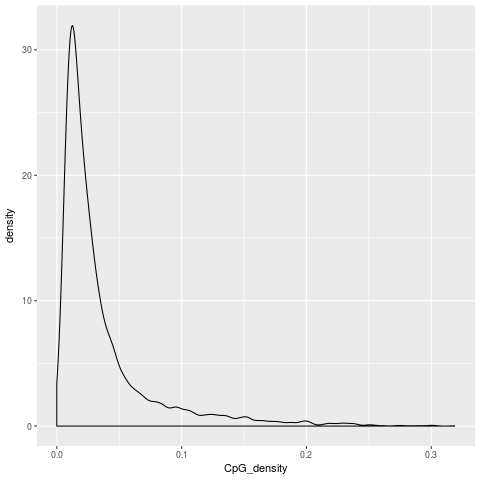

In [6]:
%R library(ggplot2)
%R p = ggplot(data, aes(x=CpG_density)) + geom_density()
%R plot(p);
